# Астероиды и кометы

## Заложим основы

In [239]:
import numba as nb
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unittest
from pathlib import Path
from PIL import Image
from IPython.display import clear_output
from IPython.core.interactiveshell import InteractiveShell
from IPython import display
from tqdm import tqdm
from dataclasses import dataclass
from numba import njit

dt = 1e-3
G = 6.7e-1
au = 149597870700

InteractiveShell.ast_node_interactivity = "all"

### Зададим объект
В моей программе только один класс, поскольку принципиальных различий между реальными небесными телами нет

In [240]:
@dataclass
class CosmicBody: 
    existance: bool  
    mass: float
    obj_radius: float
    radius_vec: np.array
    velocity_vec: np.array
    colour: str 

### Зададим методы
Их будет всего два:
- Рассчёт изменений всех параметров системы за dt (учитывает 2 возможных сценария: смещение и столкновение)
- Определение типа траектории

In [241]:
#@njit
def dtChange(syst):
    for i in range(len(syst)):
        if syst[i].existance == True:
            syst[i].radius_vec += np.dot(dt, syst[i].velocity_vec)
    
    for i in range(len(syst)):
        if syst[i].existance == True:
            for j in range(len(syst)):
                if syst[j].existance == True:
                    if j != i:
                        dr = np.array(syst[j].radius_vec) - np.array(syst[i].radius_vec)
                        syst[i].velocity_vec += np.dot(G*dt/(np.linalg.norm(dr)**3)*syst[j].mass, dr)
 
    #'''         Не работает столкновение! Без условия i != j Всегда True
    for i in range(len(syst)):
        if syst[i].existance == True:
            for j in range(len(syst)):
                if syst[j].existance == True:
                    if i != j: # Не работает столкновение! Не сталкивается вообще
                        if syst[i].mass >= syst[j].mass:
                            dr = np.linalg.norm(np.array(syst[j].radius_vec) - np.array(syst[i].radius_vec))
                            # Разобраться с размерами тел и размерами координат. Узнать почему не рисуется траектория вообще, если произошло столкновение
                            if dr < syst[i].obj_radius:
                                #print(np.linalg.norm(dr), '___', syst[i].obj_radius, '####')
                                #syst[i].velocit_vec = ( (syst[i].mass*syst[i].velocity_vec)^2 + (syst[j].mass*syst[j].velocity_vec)^2 + 2*cos(np.arccos(np.clip(np.dot(syst[i].velocity_vec, syst[j].velocity_vec), -1.0, 1.0))))**0.5/(syst[i].mass + syst[j].mass)
                                # выше попытка вычислить ЗСИ
                                syst[j].existance = False
                                syst[i].mass += syst[j].mass
                                syst[i].radius_vec += np.dot(syst[j].mass/(syst[j].mass+syst[i].mass), dr)
                                syst[i].obj_radius *= (syst[j].mass / syst[i].mass + 1)**(1/3)
                                continue
    #'''
                                      
    for i in range(len(syst)):
        if syst[i].existance == True:
            if np.linalg.norm(syst[i].radius_vec) > 100:
                syst[j].existance = False

    return syst

In [242]:
def OrbitType(syst ,CosmicBody):
    
    E_k = CosmicBody.mass *  np.linalg.norm(CosmicBody.velocity_vec) ** 2 / 2
    
    E_p = 0.0
    for i in range(len(syst)):
        if syst[i].existance == True:
            for j in range(len(syst)):
                if syst[j].existance == True:
                    dr = np.array(syst[j].radius_vec) - np.array(syst[i].radius_vec)
                    if  np.linalg.norm(dr) > 0:
                        E_p += G * syst[i].mass * syst[j].mass / np.linalg.norm(dr)
    
    if E_k - E_p > 0:
        print('hyp')
    if E_k - E_p == 0:
        print('parab')
    if E_k - E_p < 0:
        print('Ellip')

In [243]:
def plotter(syst):
        """
        The basic function to plot orbits of bodies.
        Can be used for 2 and 3 dimensional space.
        Show plot.

        Parameters
        ----------
        syst : list of objects of class Body
        """

        X_coord = np.zeros((len(syst), 1000000))
        Y_coord = np.zeros((len(syst), 1000000))
        #Z_coord = np.arange(len(syst)*1000000).reshape(len(syst),1000000)
        
        for i in range(10000):
                syst = dtChange(syst)
                for j in range(len(syst)):
                        if syst[j].existance == True:
                                X_coord[j][i] = syst[j].radius_vec[0]
                                Y_coord[j][i] = syst[j].radius_vec[1]

        plt.figure(figsize=(10, 10))
        plt.xlim(-15, 15)
        plt.ylim(-15, 15)

        for j in range(len(syst)):
                plt.scatter(X_coord[j,0], Y_coord[j,0], s=10, c = 'k')
                plt.scatter(X_coord[j], Y_coord[j], s=0.01, c = syst[j].colour)
        '''
        plt.scatter(X_coord[1], Y_coord[1], s=1, c = 'g')
        plt.scatter(X_coord[2], Y_coord[2], s=1, c = 'b')
        plt.scatter(X_coord[3], Y_coord[3], s=1, c = 'black')'''
        for j in range(len(syst)):
                if syst[j].existance == True:
                        plt.scatter(X_coord[j,9999], Y_coord[j,9999], s=syst[j].obj_radius*1000, c = syst[j].colour)
        # plt.scatter(0, 0, s=300000, c = 'r')  s = 300 000 := 30 клеток. Поэтому домножаем на 10 000 радиус
        plt.show()

        '''for i in range(len(syst)):
                plt.scatter(X_coord[i], Y_coord[i], s=1)

        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)

        x = syst[0].obj_radius * np.outer(np.cos(u), np.sin(v))
        y = syst[0].obj_radius * np.outer(np.sin(u), np.sin(v))
        z = syst[0].obj_radius * np.outer(np.ones(np.size(u)), np.cos(v))
        plt.plot_surface(x, y, z, rstride=4, cstride=4, color='r', linewidth=0, alpha=0.5)
        plt.plot_surface(x, y, -z, rstride=4, cstride=4, color='r', linewidth=0, alpha=0.5)'''

        
        '''
        star = plt.Circle((0, 0), syst[0].obj_radius, color='r')
        plt.gca().add_patch(star)'''

### Тесты

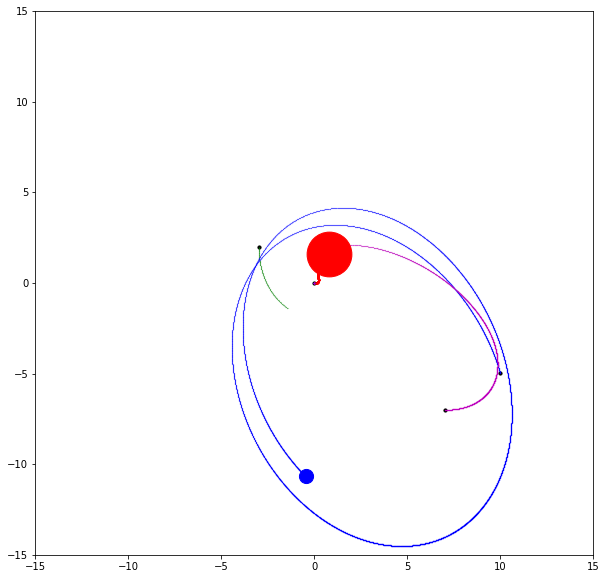

Ellip


In [244]:
#             existance    mass     obj_radius  radius_vec      velocity_vec   colour
Big   = CosmicBody(True,   1000,    2,          [0.0,0.0],      [.0, .0],      'r') 
Body1 = CosmicBody(True,   1,       0.1,          [-3.0, 2.0],    [.0, -15.0],   'g')
Body2 = CosmicBody(True,   20,      0.2,          [10.0, -5.0],   [-2.0, 7.0],   'b')
Body3 = CosmicBody(True,   5,       0.05,        [7.0, -7.0],    [5.0, .0],     'm')

syst  = [Big, Body1, Body2, Body3]
plotter(syst)
OrbitType(syst, Body1)